run MFVB time:  0:00:00.000858
run Gibbs Sampling time:  0:00:00.800327
run FFVBcv time:  0:00:19.807796
alpha_MFVB:  6.0
beta_MFVB:  19.031928340325976
mu_MFVB:  9.401776763928614
sigam2_MFVB:  0.3074466351251396
iter:  7
alpha_MCMC:  4.965380394798395
beta_MCMC:  15.669100853144116
mu_MCMC:  9.339948841534477
sigma2_MCMC:  0.4158401405894608
Samplers:  20000
alpha_FFVBcv:  5.87445260718272
beta_FFVBcv:  18.70268578372742
mu_FFVBcv:  9.387448322654725
sigma2_FFVBcv:  0.35971017351757206
iter:  307


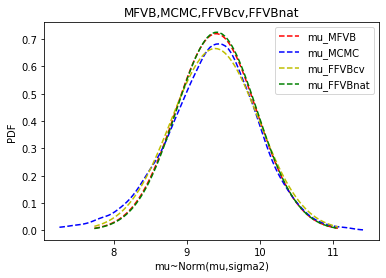

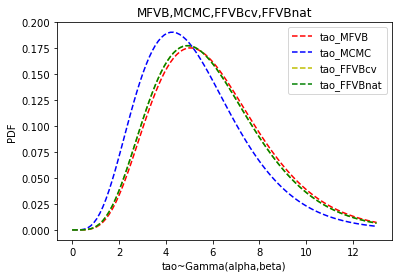

In [4]:
# MFVB,Gibbs Sampling,FFVBcv CODE Reference from VBayesLab
import numpy as np
import scipy.stats as stats
import math
from numpy import linalg as LA
from scipy.special import psi
import pandas as pd
import matplotlib.pyplot as plt

y = np.array([11, 12, 8, 10, 9, 8, 9, 10, 13, 7]) #data

#run MFVB
y_bar = np.mean(y)
sum_y2 = 0
n = len(y)
for i in range(n):
    sum_y2 +=y[i]**2
alpha0 = 1
beta0 = 1
mu0 = 0
sigma20 = 10
muq = y_bar #initialise muq
sigma2q = 1 #initialise sigma2q
eps = 10e-5 #threshod value
alphaq = alpha0+n/2 #update alpha
betaq = beta0+sum_y2/2-n*y_bar*muq+n*(muq**2+sigma2q)/2 #update beta
parameter_new = np.array([alpha0,beta0,mu0,sigma20])
from datetime import datetime
start=datetime.now()
iterInx = 0
parameter_old = np.array([0,0,0,0])
while LA.norm(parameter_new-parameter_old)>eps:
    parameter_old = parameter_new
    betaq = beta0+sum_y2/2-n*y_bar*muq+n*(muq**2+sigma2q)/2 # update beta_q. No need to update alpha_q
    sigma2q = 1/(1/sigma20+n*alphaq/betaq) # update sigma2_q
    muq = (mu0/sigma20+n*y_bar*alphaq/betaq)*sigma2q # update mu_q
    parameter_new = np.array([alphaq,betaq,muq,sigma2q])
    iterInx+=1
print("run MFVB time: ", datetime.now()-start)    
    
#run Gibbs Sampling
start=datetime.now()
Nburn = 10000
Niter = 20000
N = Nburn + Niter
mu_mcmc = np.zeros(N)
sigma2_mcmc = np.zeros(N)
i = 1
mu_mcmc[1] = y_bar 
sigma2_mcmc[1] = np.var(y) #nitial value
while i<N-1:
    scale = 1/(1/sigma20+n/sigma2_mcmc[i])
    location = n*y_bar/sigma2_mcmc[i]*scale
    mu_mcmc[i+1] = np.random.normal(location,np.sqrt(scale))
    aux = np.random.gamma(n/2+alpha0,1/(beta0+sum((y-mu_mcmc[i+1])**2)/2))
    sigma2_mcmc[i+1] = 1/aux
    i = i+1 
mu_mcmc = mu_mcmc[Nburn+1:N]
sigma2_mcmc = sigma2_mcmc[Nburn+1:N]
E = np.mean(sigma2_mcmc)
V = np.var(sigma2_mcmc)
alpha_mcmc = E**2/V+2
beta_mcmc = (alpha_mcmc-1)*E
print("run Gibbs Sampling time: ", datetime.now()-start)

#FFVBcv
start=datetime.now()
d = 4
S = 500  #number of Monte Carlo samples
beta1_adap_weight = 0.9 # adaptive learning weight
beta2_adap_weight = 0.9 # adaptive learning weight
eps0 = 0.1
w_adadelta = 0.95 # adaptive learning weight
eps_adadelta = 1e-7 # adaptive learning eps
   
max_iter = 2000
patience_max = 20
tau_threshold = max_iter/2
t_w = 50
#hyperparameter
alpha_hp = 1
beta_hp = 1
mu_hp = 0
sigma2_hp = 10

lambdaq = np.array([np.mean(y),1.5,2,3]).reshape(1,4)# initial lambdaq
lambda_best = lambdaq

#function h_lambda_fun
def h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2):
    log_p_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_hp)-(mu-mu_hp)**2/2/sigma2_hp
    log_p_sigma2 = alpha_hp*np.log(beta_hp)-np.log(math.gamma(alpha_hp))-(alpha_hp+1)*np.log(sigma2)-beta_hp/sigma2
    log_q_mu = -1/2*np.log(2*np.pi)-1/2*np.log(sigma2_mu)-(mu-mu_mu)**2/2/sigma2_mu
    log_q_sigma2 = alpha_sigma2*np.log(beta_sigma2)-np.log(math.gamma(alpha_sigma2))-(alpha_sigma2+1)*np.log(sigma2)-beta_sigma2/sigma2;
    llh = -n/2*np.log(2*np.pi)-n/2*np.log(sigma2)-1/2/sigma2*sum((y-mu)**2)
    return log_p_mu+log_p_sigma2+llh-log_q_mu-log_q_sigma2

mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
alpha_sigma2 = lambdaq[0,2]
beta_sigma2 = lambdaq[0,3]
h_lambda = np.zeros((S,1))#  function h_lambda
grad_log_q_lambda = np.zeros((S,d))
grad_log_q_times_h = np.zeros((S,d))
for s in range(S):
    mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
    sigma2 = 1./np.random.gamma(alpha_sigma2,1/beta_sigma2,1)

    grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                     -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2,
                                     np.log(beta_sigma2)-psi(alpha_sigma2)-np.log(sigma2),
                                     alpha_sigma2/beta_sigma2-1/sigma2]).reshape(1,4)
    h_lambda[s] = h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2)    
    grad_log_q_times_h[s,:] = grad_log_q_lambda[s,:]*h_lambda[s]

cv = np.zeros((1,d))# control variate
for i in range(d):
    aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
    cv[0,i] = aa[0,1]/aa[1,1]

grad_LB1= np.mean(grad_log_q_times_h[:,0])
grad_LB2= np.mean(grad_log_q_times_h[:,1])
grad_LB3= np.mean(grad_log_q_times_h[:,2])
grad_LB4= np.mean(grad_log_q_times_h[:,3])
grad_LB =np.array([grad_LB1,grad_LB2,grad_LB3,grad_LB4]).reshape(1,4)

#ADAM
g_adaptive = grad_LB
v_adaptive = g_adaptive**2
g_bar_adaptive = g_adaptive
v_bar_adaptive = v_adaptive

iter_ = 1
stop = False
LB = np.array([-1e3 for i in range(2000)])
LB_bar = np.array([-1e3 for i in range(2000)])
patience = 0  

while not stop:
    mu_mu = lambdaq[0,0]
    sigma2_mu = lambdaq[0,1]
    alpha_sigma2 = lambdaq[0,2]
    beta_sigma2 = lambdaq[0,3]
    h_lambda = np.zeros((S,1))# function h_lambda
    grad_log_q_lambda = np.zeros((S,d))
    grad_log_q_times_h = np.zeros((S,d))
    grad_log_q_times_h_cv = np.zeros((S,d))
    for s in range(S):
        mu = np.random.normal(mu_mu,math.sqrt(sigma2_mu),1)
        sigma2 = 1./np.random.gamma(alpha_sigma2,1/beta_sigma2,1)

        grad_log_q_lambda[s,:]=np.array([(mu-mu_mu)/sigma2_mu,
                                     -1/2/sigma2_mu+(mu-mu_mu)**2/2/sigma2_mu**2,
                                     np.log(beta_sigma2)-psi(alpha_sigma2)-np.log(sigma2),
                                     alpha_sigma2/beta_sigma2-1/sigma2]).reshape(1,4)
        h_lambda[s] = h_lambda_fun(y,mu,sigma2,alpha_hp,beta_hp,mu_hp,sigma2_hp,mu_mu,sigma2_mu,alpha_sigma2,beta_sigma2)    
        grad_log_q_times_h[s,:] = grad_log_q_lambda[s,:]*h_lambda[s]
        grad_log_q_times_h_cv[s,:] = grad_log_q_lambda[s,:]*(h_lambda[s]-cv)
    cv = np.zeros((1,d))# control variate
    for i in range(d):
        aa = np.cov(grad_log_q_times_h[:,i],grad_log_q_lambda[:,i])
        cv[0,i] = aa[0,1]/aa[1,1]

    grad_LB1= np.mean(grad_log_q_times_h_cv[:,0])
    grad_LB2= np.mean(grad_log_q_times_h_cv[:,1])
    grad_LB3= np.mean(grad_log_q_times_h_cv[:,2])
    grad_LB4= np.mean(grad_log_q_times_h_cv[:,3])
    grad_LB =np.array([grad_LB1,grad_LB2,grad_LB3,grad_LB4]).reshape(1,4)
    g_adaptive = grad_LB
    v_adaptive = g_adaptive**2
    g_bar_adaptive = beta1_adap_weight*g_bar_adaptive+(1-beta1_adap_weight)*g_adaptive
    v_bar_adaptive = beta2_adap_weight*v_bar_adaptive+(1-beta2_adap_weight)*v_adaptive

    if iter_>=tau_threshold:
        stepsize = eps0*tau_threshold/iter_
    else:
        stepsize = eps0

    lambdaq = lambdaq+stepsize*g_bar_adaptive/np.sqrt(v_bar_adaptive)

    LB[iter_] = np.mean(h_lambda)

    if iter_>=t_w:
        LB_bar[iter_-t_w+1] = np.mean(LB[iter_-t_w+1:iter_])
        LB_bar[iter_-t_w+1]
        
    if iter_>t_w:
        if LB_bar[iter_-t_w+1]>=max(LB_bar):
            lambda_best = lambdaq
            patience = 0
        else:
            patience = patience+1
    if patience>patience_max or iter_>max_iter:
        stop = True
    iter_ = iter_+1
    
lambdaq = lambda_best
mu_mu = lambdaq[0,0]
sigma2_mu = lambdaq[0,1]
alpha_sigma2 = lambdaq[0,2]
beta_sigma2 = lambdaq[0,3]  
print("run FFVBcv time: ", datetime.now()-start)

#plot(MFVB,Gibbs,FFVBcv,FFVB_NSGD)
print("=======================================")
print("alpha_MFVB: ", parameter_new[0])
print("beta_MFVB: ", parameter_new[1])
print("mu_MFVB: ", parameter_new[2])
print("sigam2_MFVB: ", parameter_new[3])
print("iter: ", iterInx)
print("=======================================")
print("alpha_MCMC: ", alpha_mcmc)
print("beta_MCMC: ", beta_mcmc)
print("mu_MCMC: ", np.mean(mu_mcmc))
print("sigma2_MCMC: ", np.var(mu_mcmc))
print("Samplers: ", Niter)
print("=======================================")
print("alpha_FFVBcv: ", alpha_sigma2)
print("beta_FFVBcv: ", beta_sigma2)
print("mu_FFVBcv: ", mu_mu)
print("sigma2_FFVBcv: ", sigma2_mu)
print("iter: ", iter_)
#NatrualGradient [9.43430498  0.28768531  5.72433245 17.7034807]
sigmaq = np.sqrt(sigma2q)
x = np.linspace(muq - 3*sigmaq, muq + 3*sigmaq, 100)
#plot MFVB
plt.plot(x, stats.norm.pdf(x, muq, sigmaq),"r--",label="mu_MFVB")
plt.title('MFVB,MCMC,FFVBcv,FFVBnat') 
plt.xlabel('mu~Norm(mu,sigma2)'); plt.ylabel('PDF')
#plot Gibbs Sampling
data = mu_mcmc
kde = stats.gaussian_kde(data)
y = np.linspace(np.mean(data)-5*np.var(data), np.mean(data)+5*np.var(data), 100)
p = kde(y)
plt.plot(y,p,"b--",label="mu_MCMC")
plt.plot(x, stats.norm.pdf(x, mu_mu, np.sqrt(sigma2_mu)),"y--",label="mu_FFVBcv")
plt.plot(x, stats.norm.pdf(x, 9.40960456250042, np.sqrt(0.30303991610297387)),"g--",label="mu_FFVBnat")
plt.legend()
plt.show()

# convert invgamma to gamma
tao = []
for i in range(len(sigma2_mcmc)):
    tao.append(1/sigma2_mcmc[i])
tao_mu = np.mean(tao) #mcmc
tao_sigma2 = np.var(tao)
beta_tao = tao_mu/tao_sigma2
alpha_tao = beta_tao*tao_mu
x = np.linspace (0, 13, 100) 
y1 = stats.gamma.pdf(x, a=alphaq, loc=1/betaq)#MFVB
plt.plot(x, y1, "r--", label="tao_MFVB") 
y2 = stats.gamma.pdf(x, a=alpha_tao, loc=1/beta_tao)#MCMC
plt.plot(x, y2, "b--", label="tao_MCMC")
y3 = stats.gamma.pdf(x, a=alpha_sigma2, loc=1/beta_sigma2)#FFVBcv
plt.plot(x, y3, "y--", label="tao_FFVBcv")
y4 = stats.gamma.pdf(x, a=5.62103199180137, loc=1/17.841106430055973)#FFVBnat
plt.plot(x, y3, "g--", label="tao_FFVBnat")
#y2 = stats.gamma.pdf(x, a=alpha_mcmc, loc=1/beta_mcmc)
#plt.plot(x, y2, "y--", label=(r'$\alpha=5.1, \beta=1/16.5'))
plt.title('MFVB,MCMC,FFVBcv,FFVBnat') 
plt.xlabel('tao~Gamma(alpha,beta)'); plt.ylabel('PDF')
plt.legend()
plt.show()